In [4]:
"""
UNet paper link:
https://arxiv.org/pdf/1505.04597.pdf
This is a newer version implementation of the UNet paper for high resolution
image segmentation.

Basically the main difference is that in the original
paper, the authors had not zero padded while carrying out convolution
operations. But, in this implementation we are zero padding the double
convolution operations.

So, what is the benefit of this? We will get the same size output as the
input and can drop the cropping part totally.
"""

'\nUNet paper link:\nhttps://arxiv.org/pdf/1505.04597.pdf\nThis is a newer version implementation of the UNet paper for high resolution\nimage segmentation.\n\nBasically the main difference is that in the original\npaper, the authors had not zero padded while carrying out convolution\noperations. But, in this implementation we are zero padding the double\nconvolution operations.\n\nSo, what is the benefit of this? We will get the same size output as the\ninput and can drop the cropping part totally.\n'

In [5]:
import os
import torch
import torch.nn as nn
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **DataLoading & Splitting**

In [8]:
dataset_path = '/content/drive/MyDrive/LungTumorDetectionAndSegmentation'

In [9]:
class LungTumorSegmentationDataset(Dataset):

    def __init__(self, root_path, transform=None, mask_transform=None):

        self.images = []
        for subject in os.listdir(os.path.join(root_path, 'images')):
            subject_path = os.path.join(root_path, 'images', subject)
            for image_file in os.listdir(subject_path):
                self.images.append(os.path.join(subject_path, image_file))

        self.masks = [img_path.replace('images', 'masks') for img_path in self.images]
        self.transform = transform
        self.mask_transform = mask_transform


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):

        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path).convert("L")  # grayscale image
        mask = Image.open(mask_path).convert("L")    # mask as single-channel

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0.5).float()  # Ensure binary values

        return image_path, image, mask

In [10]:
image_transform = T.Compose([
                              T.Resize((256, 256)),
                              T.ToTensor(),
                           ])

In [11]:
train_dataset = LungTumorSegmentationDataset(os.path.join(dataset_path, 'train'), image_transform, image_transform)
val_dataset = LungTumorSegmentationDataset(os.path.join(dataset_path, 'val'), image_transform, image_transform)

In [12]:
print('Length of the training data:', len(train_dataset))
print('Length of the validation data:', len(val_dataset))

Length of the training data: 1832
Length of the validation data: 98


In [13]:
print('Length of the training data:', len(train_dataset))
print('Length of the validation data:', len(val_dataset))

Length of the training data: 1832
Length of the validation data: 98


In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
train_batches = iter(train_dataloader)
val_batches = iter(val_dataloader)

for train_sample, val_sample in zip(train_batches, val_batches):
    print('Shape of the first training sample & corresponding mask:', train_sample[1][0].shape, train_sample[2][0].shape)
    print('Shape of the first validation sample & corresponding mask:', val_sample[1][0].shape, val_sample[2][0].shape)
    break

Shape of the first training sample & corresponding mask: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Shape of the first validation sample & corresponding mask: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


## **UNet Architecture**

In [16]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),

                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
                           )
    return conv_op

In [17]:
class UNet(nn.Module):


    def __init__(self, num_classes):

        super(UNet, self).__init__()

        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path.

        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)


        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
                                                in_channels=1024, out_channels=512,
                                                kernel_size=2,
                                                stride=2)

        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)

        self.up_transpose_2 = nn.ConvTranspose2d(
                                                  in_channels=512, out_channels=256,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_2 = double_convolution(512, 256)

        self.up_transpose_3 = nn.ConvTranspose2d(
                                                  in_channels=256, out_channels=128,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_3 = double_convolution(256, 128)

        self.up_transpose_4 = nn.ConvTranspose2d(
                                                  in_channels=128, out_channels=64,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_4 = double_convolution(128, 64)

        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
                              in_channels=64, out_channels=num_classes,
                              kernel_size=1
                            )



    def forward(self, x):

        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))

        out = self.out(x)

        return out

In [18]:
input_image = torch.rand((1, 1, 512, 512))
model = UNet(num_classes=10)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

outputs = model(input_image)
print(outputs.shape)

31,031,178 total parameters.
31,031,178 training parameters.
torch.Size([1, 10, 512, 512])


## **Training & Evaluation Functions**

In [19]:
def train_model(train_loader, val_loader, model, criterion, lr, n_epochs, device):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Fixed optimizer to use torch.optim.Adam
    model.train()

    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(n_epochs):

        print(f'Epoch [{epoch+1}/{n_epochs}] Started')

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # Training loop
        for images_path, images, masks in train_loader:

            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()  # Zero the gradients before the backward pass

            output = model(images)

            loss = criterion(output, masks)
            epoch_train_loss += loss.item()

            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model parameters

        epoch_train_loss /= len(train_loader)  # Average training loss
        epoch_train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        with torch.no_grad():  # No gradient calculation for validation

            for images_path, images, masks in val_loader:

                images, masks = images.to(device), masks.to(device)

                output = model(images)

                loss = criterion(output, masks)
                epoch_val_loss += loss.item()

        epoch_val_loss /= len(val_loader)  # Average validation loss
        epoch_val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{n_epochs}] Finished, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}\n\n')


    return epoch_train_losses, epoch_val_losses

## **Train & Evaluate the model**

In [20]:
model = UNet(num_classes=1).to(device)

In [62]:
model.load_state_dict(torch.load(f"/content/drive/MyDrive/unet_lung_segmentation_{epoch_val_losses[-1]}.pth", map_location=device))
model.to(device)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(51

In [63]:
criterion = nn.BCEWithLogitsLoss()

In [64]:
# Train the model
epoch_train_losses, epoch_val_losses = train_model(train_dataloader, val_dataloader, model, criterion, lr=0.001, n_epochs=20, device=device)

Epoch [1/20] Started
Epoch [1/20] Finished, Train Loss: 0.0232, Val Loss: 0.0085


Epoch [2/20] Started
Epoch [2/20] Finished, Train Loss: 0.0226, Val Loss: 0.0085


Epoch [3/20] Started
Epoch [3/20] Finished, Train Loss: 0.0227, Val Loss: 0.0085


Epoch [4/20] Started
Epoch [4/20] Finished, Train Loss: 0.0225, Val Loss: 0.0083


Epoch [5/20] Started
Epoch [5/20] Finished, Train Loss: 0.0225, Val Loss: 0.0083


Epoch [6/20] Started
Epoch [6/20] Finished, Train Loss: 0.0225, Val Loss: 0.0083


Epoch [7/20] Started
Epoch [7/20] Finished, Train Loss: 0.0224, Val Loss: 0.0083


Epoch [8/20] Started
Epoch [8/20] Finished, Train Loss: 0.0225, Val Loss: 0.0083


Epoch [9/20] Started
Epoch [9/20] Finished, Train Loss: 0.0239, Val Loss: 0.0080


Epoch [10/20] Started
Epoch [10/20] Finished, Train Loss: 0.0234, Val Loss: 0.0082


Epoch [11/20] Started
Epoch [11/20] Finished, Train Loss: 0.0228, Val Loss: 0.0086


Epoch [12/20] Started
Epoch [12/20] Finished, Train Loss: 0.0228, Val Loss: 0.0083


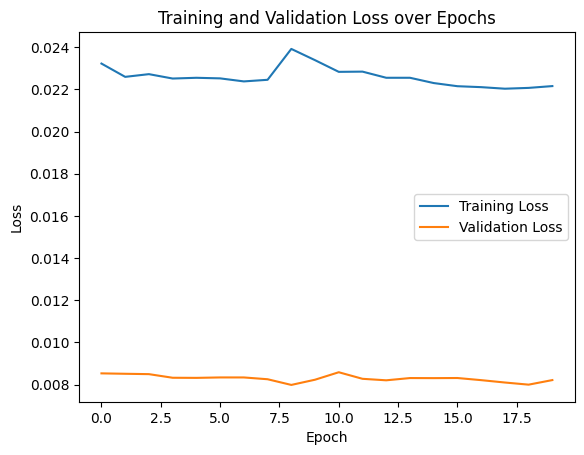

In [65]:
# Plot training and validation losses
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

## **Save the model**

In [66]:
# Save the trained model
torch.save(model.state_dict(), f"/content/drive/MyDrive/unet_lung_segmentation_{epoch_val_losses[-1]}.pth")

## **Inference**

In [67]:
# Reinitialize the model
model = UNet(num_classes=1)  # For binary segmentation
model.load_state_dict(torch.load(f"/content/drive/MyDrive/unet_lung_segmentation_{epoch_val_losses[-1]}.pth", map_location=device))
model.to(device)
model.eval()

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(51

Before Sigmoid Output stats: -34.823699951171875 -0.40002718567848206
After Sigmoid Output stats: 7.520717129607063e-16 0.40130582451820374
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


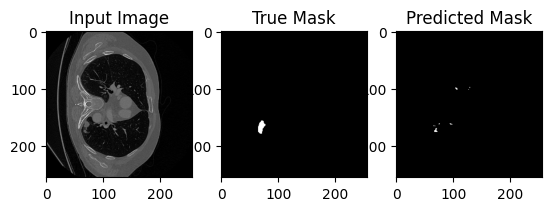

In [72]:
# Load the image and preprocess
image_path = val_dataset[10][0]
true_mask_path = val_dataset[10][0].replace('images', 'masks')


image = Image.open(image_path).convert("L")              # Convert to grayscale
true_mask = Image.open(true_mask_path).convert("L")      # Convert to grayscale


# Define transform (same as training)
transform = T.Compose([
                        T.Resize((256, 256)),  # adjust to match training input size
                        T.ToTensor()
                     ])


# Transform and add batch dimension
input_tensor = transform(image).unsqueeze(0).to(device)         # Shape: [1, 1, H, W]

# Forward pass
with torch.no_grad():
    output = model(input_tensor)
    print("Before Sigmoid Output stats:", output.min().item(), output.max().item())
    output = torch.sigmoid(output)      # Convert logits to probabilities
    print("After Sigmoid Output stats:", output.min().item(), output.max().item())
    pred_mask = (output > 0.2).float()  # Threshold for binary mask
    print(pred_mask)


# Visualize
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze().cpu(), cmap='gray')

plt.show()